## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [18]:
from keras.layers import BatchNormalization, Activation, Dropout
from keras.regularizers import l1_l2

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], drp_ratio=0, l2_ratio=0):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),kernel_regularizer=l1_l2(l1=0, l2=l2_ratio))(input_layer)
            x = BatchNormalization()(x)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),kernel_regularizer=l1_l2(l1=0, l2=l2_ratio))(x)
            x = BatchNormalization()(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [15]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 5
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [16]:
import itertools
dropout_ratio = [0.2,0.5,0.7]
regularization_ratio = [0,0.2,0.7]

In [21]:
results = {}
for i, (drp_ratio, l2_ratio) in enumerate(itertools.product(dropout_ratio, regularization_ratio)):
    print("Numbers of exp: %i, drp_ratio: %.2f, l2_ratio: %.2f" % (i, drp_ratio, l2_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], drp_ratio=drp_ratio, l2_ratio=l2_ratio)
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              verbose=1,
              shuffle=True)
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, drp_ratio: 0.20, l2_ratio: 0.00
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_5 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_6 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 57s 1ms/step - loss: 2.6383 - accuracy: 0.2219 - val_loss: 3.5358 - val_accuracy: 0.1827
Epoch 2/5
50000/50000 [==============================] - 57s 1ms/step - loss: 2.1804 - accuracy: 0.2725 - val_loss: 1.9741 - val_accuracy: 0.3133
Epoch 3/5
50000/50000 [==============================] - 52s 1ms/step - loss: 1.9793 - accuracy: 0.3086 - val_loss: 1.7329 - val_accuracy: 0.3753
Epoch 4/5
50000/50000 [==============================] - 52s 1ms/step - loss: 1.8730 - accuracy: 0.3338 - val_loss: 1.7004 - val_accuracy: 0.3888
Epoch 5/5
50000/50000 [==============================] - 49s 986us/step - loss: 1.7965 - accuracy: 0.3556 - val_loss: 1.7868 - val_accuracy: 0.3576
Numbers of exp: 4, drp_ratio: 0.50, l2_ratio: 0.20
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLaye

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 79s 2ms/step - loss: 3.3555 - accuracy: 0.1473 - val_loss: 8.1561 - val_accuracy: 0.1071
Epoch 2/5
50000/50000 [==============================] - 78s 2ms/step - loss: 2.6336 - accuracy: 0.1864 - val_loss: 2.5448 - val_accuracy: 0.2497
Epoch 3/5
50000/50000 [==============================] - 78s 2ms/step - loss: 2.3116 - accuracy: 0.2156 - val_loss: 1.9134 - val_accuracy: 0.3076
Epoch 4/5
50000/50000 [==============================] - 79s 2ms/step - loss: 2.1298 - accuracy: 0.2375 - val_loss: 1.9068 - val_accuracy: 0.2924
Epoch 5/5
50000/50000 [==============================] - 78s 2ms/step - loss: 2.0321 - accuracy: 0.2543 - val_loss: 1.9096 - val_accuracy: 0.2986
Numbers of exp: 7, drp_ratio: 0.70, l2_ratio: 0.20
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer

In [23]:
results

{'exp-0': {'train-loss': [2.063033457183838,
   1.745899759941101,
   1.640391693649292,
   1.576889299659729,
   1.532276081428528],
  'valid-loss': [3.045583006286621,
   1.7613877653121948,
   1.717785012435913,
   1.617250926399231,
   1.5791025108337402],
  'train-acc': [0.30958, 0.38502, 0.42066, 0.44064, 0.4576],
  'valid-acc': [0.19539999961853027,
   0.3725000023841858,
   0.375900000333786,
   0.41920000314712524,
   0.4325000047683716]},
 'exp-1': {'train-loss': [97.5928529083252,
   11.054117127990722,
   3.6430859841156007,
   2.570981497039795,
   2.3874988228607177],
  'valid-loss': [21.810626931762695,
   5.606152402496338,
   3.2581542446136473,
   2.925288806915283,
   2.855246720123291],
  'train-acc': [0.28436, 0.33058, 0.3452, 0.35146, 0.3587],
  'valid-acc': [0.17630000412464142,
   0.1111999973654747,
   0.10050000250339508,
   0.12929999828338623,
   0.1298999935388565]},
 'exp-2': {'train-loss': [325.7727708544922,
   31.324133081054686,
   6.439319769134522,
 

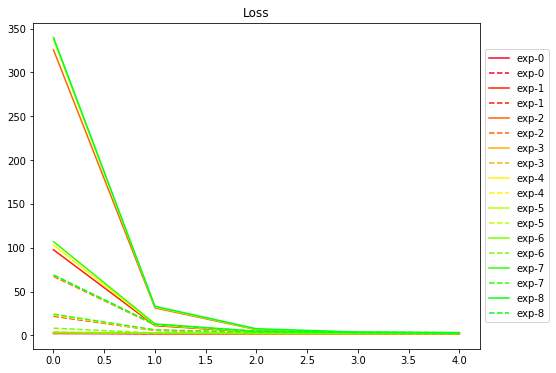

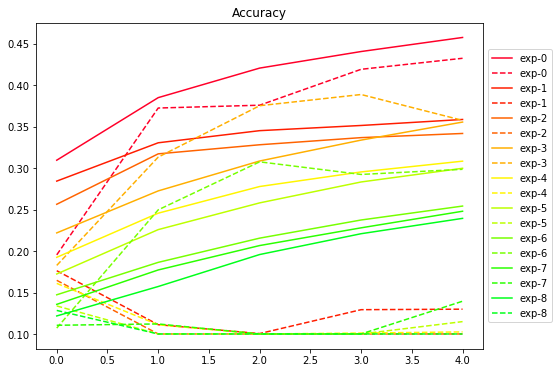

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = 20

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()